<center>
<img src="https://neurohive.io/wp-content/uploads/2018/08/perseptron-mnogosloinyi.gif" width="700"> 

# Семинар 8: кошки против собак и transfer learning 
</center>
<br>

На этой паре мы обучим нейросетку отличать кошек от собак. Если вы ещё не забыли лекцию про свёрточные сетки, в $2013$ году это было непростой задачкой. Настолько, что [к соревнованию на Kaggle](https://www.kaggle.com/c/dogs-vs-cats) висит такое предысловие:

> В 1997 году Deep Blue обыграл в шахматы Каспарова.  В 2011 Watson обставил чемпионов Jeopardy. Сможет ли ваш алгоритм в 2013 году отличить Бобика от Пушистика?

В этом семинаре мы попробуес сделать Transfer learning и посмотрим какое качество будет у нашей модели.

# Что такое transfer learning? 

Каждый раз, обучая нейронку, мы сначала рандомно инициализируем веса, а после в ходе бэкпропа обучаем модель. Если мы сразу же угадываем хорошие веса, модель сходится быстрее. Иногда можно брать в качестве инициализации веса, полученные другими исследователями и на их основе дообучать модель под свой выход. Это здорово упрощает задачу обучения и экономит недели работы.

- __Transfer learning__ - это когда ты заморозил все веса, кроме последних слоёв, а последнии слои дообучил под свою задачу 
- __Fine-tuning__ - это когда ты использовал веса предобученной модели как инициализацию и менял их в ходе дообучения

- [туториал от pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np

from tqdm.auto import tqdm
import os 
import shutil

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

# 1. Реквизируем модель

In [4]:
import torch
from torchvision.models import mobilenet_v3_small
from torchvision import transforms as T
from PIL import Image

In [5]:
model = mobilenet_v3_small(weights="IMAGENET1K_V1")
model.eval()
sum(param.numel() for param in model.parameters())

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 75.2MB/s]


2542856

Скачаем json с расшифровкой классов Imagenet

In [6]:
%%bash
wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
wget https://i.natgeofe.com/k/66d3a80c-f4c3-4410-845c-3543375eaa85/cheetah-watching_square.jpg -O cheetah.jpg

In [7]:
import json
class_idx = json.load(open('imagenet_class_index.json'))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

Попробуем скачать из интернета какую-нибудь картинку и предсказать её класс.

In [8]:
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

In [9]:
@torch.no_grad()
def predict(image):
    probs = model(
        transform(image).unsqueeze(0)
    ).squeeze().softmax(dim=0)

    class_id = probs.argmax().item()
    print(f'class ID: {class_id}, class name: {idx2label[class_id]}, '
          f'confidence: {100 * probs[class_id].item():.2f}%')

In [10]:
!wget 'https://lookw.ru/1/134/1380316134-gepardi----37.jpg'

--2023-04-12 13:31:40--  https://lookw.ru/1/134/1380316134-gepardi----37.jpg
Resolving lookw.ru (lookw.ru)... 172.67.188.123, 104.21.19.186, 2606:4700:3034::6815:13ba, ...
Connecting to lookw.ru (lookw.ru)|172.67.188.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2178827 (2.1M) [image/jpeg]
Saving to: ‘1380316134-gepardi----37.jpg’

1380316134-gepardi- 100%[===================>]   2.08M  3.19MB/s    in 0.7s    

2023-04-12 13:31:41 (3.19 MB/s) - ‘1380316134-gepardi----37.jpg’ saved [2178827/2178827]



class ID: 293, class name: cheetah, confidence: 99.13%


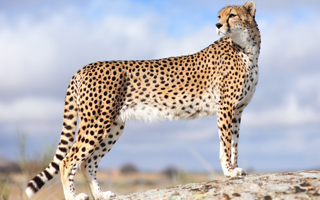

In [18]:
image = Image.open('1380316134-gepardi----37.jpg')
predict(image)
image.resize([item // 8 for item in image.size])

In [12]:
!wget 'https://sun9-34.userapi.com/c850216/v850216669/110118/s1XSv_XLgtY.jpg'

--2023-04-12 13:31:49--  https://sun9-34.userapi.com/c850216/v850216669/110118/s1XSv_XLgtY.jpg
Resolving sun9-34.userapi.com (sun9-34.userapi.com)... 93.186.227.145
Connecting to sun9-34.userapi.com (sun9-34.userapi.com)|93.186.227.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222549 (217K) [image/jpeg]
Saving to: ‘s1XSv_XLgtY.jpg’

s1XSv_XLgtY.jpg     100%[===================>] 217.33K   510KB/s    in 0.4s    

2023-04-12 13:31:50 (510 KB/s) - ‘s1XSv_XLgtY.jpg’ saved [222549/222549]



class ID: 841, class name: sweatshirt, confidence: 10.20%


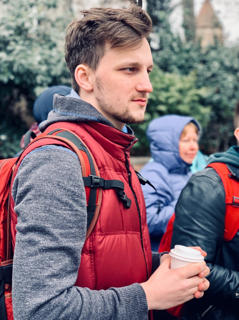

In [15]:
image = Image.open('s1XSv_XLgtY.jpg')#.resize([item // 2 for item in image.size])
predict(image)
image.resize([item // 3 for item in image.size])

Для гепарда сработало хорошо, для меня не очень. Моя фотка классифицирована как свитшот. Дело в том, что в `ImageNet` нет людей. Поэтому нейросетка не может выдать адекватный прогноз и цепляется за мою одежду.

In [ ]:
##############################################################################
###  Попробуйте подгрузить свои нюдсы и посмотреть, как вас классифицирует 
##############################################################################

# 2. Данные

Скачаем данные

In [19]:
%%bash
wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
unzip -q cats_and_dogs_filtered.zip
rm cats_and_dogs_filtered.zip
rm cats_and_dogs_filtered/vectorize.py

In [20]:
!ls cats_and_dogs_filtered

train  validation


In [21]:
!ls cats_and_dogs_filtered/train

cats  dogs


Посмотрим, сколько весят данные.

In [22]:
!du -sh cats_and_dogs_filtered

72M	cats_and_dogs_filtered


Все файлы сейчас лежат по папкам, которые соотвествуют классам.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

In [23]:
wd = !pwd
path = wd[0] + '/'
path

'/content/'

In [24]:
xd = os.listdir(path + 'cats_and_dogs_filtered/train/dogs')
xc = os.listdir(path + 'cats_and_dogs_filtered/train/cats')
len(xd), len(xc)

(1000, 1000)

In [25]:
xd = os.listdir(path + 'cats_and_dogs_filtered/validation/dogs')
xc = os.listdir(path + 'cats_and_dogs_filtered/validation/cats')

test_cnt = len(xd) + len(xc)
len(xd), len(xc)

(500, 500)

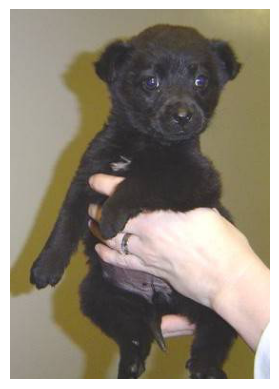

In [26]:
import glob

file = np.random.choice(glob.glob(path + "/cats_and_dogs_filtered/*/*/*.jpg"))
plt.axis("off")
plt.imshow(plt.imread(file));

Итак, у нас есть $2000$ наблюдений в обучающей выборке и $1000$ в тестовой. Все файлы лежат на компьютере. Нам надо будет как-то доставать эти файлы и передавать их в нейросеть. Из обучающей выборки нужно выделить валидационную. 

Мы попробуем два подхода. Возьмём уже готовый `Dataset`, а потом напишем свой. 

# 3. Поставка данных встроенными методами 

In [27]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split

print(torchvision.__version__)

0.15.1+cu118


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [29]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

dataset = ImageFolder(
    path + "/cats_and_dogs_filtered/train",
    transform = test_transform
)

In [30]:
dataset.classes

['cats', 'dogs']

In [31]:
image, label = next(iter(dataset))

In [32]:
dataset.classes[label]

'cats'

In [33]:
image.shape

torch.Size([3, 224, 224])

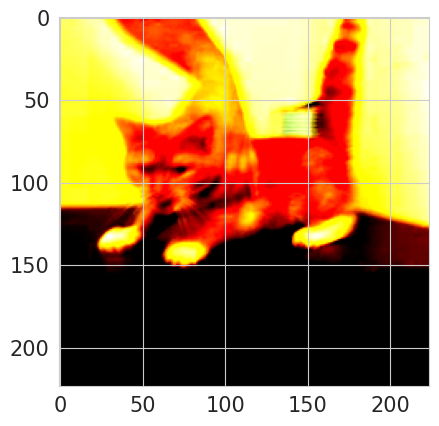

In [34]:
# картинка всратая из-за нормализаций в трансформере
plt.imshow(np.transpose(image, (1, 2, 0)));

In [46]:
# создаём встроенными методами два датасета :) 
train_simple_set, val_simple_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

In [47]:
train_simple_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
val_simple_dataloader = DataLoader(val_set, batch_size=256, shuffle=False, pin_memory=True, num_workers=4)

Этими даталоадерами можно спокойно пользоваться для обучения моделей. Давайте попробуем написать код с собственным датасетом.

# 4. Пишем свой собственный датасет

Эта часть тетрадки [взята у Ильдуса.](https://github.com/isadrtdinov/intro-to-dl-hse/blob/2022-2023/seminars/202/seminar-04-fine-tuning.ipynb) Если вы не понимаете, что в ней происходит, [можно посмотреть видео,](https://www.youtube.com/watch?v=1wCd23p2l98&list=PLEwK9wdS5g0onnKgvKxuUJN1Ojchl9Q9P&index=9) где Ильдус лайфкодит этот датасет.

Иногда так бывает, что базовая подгрузка данных нас не устраивает. В таком случае мы должны написать свой собственный датасет. 

`Dataset` умеет выдавать по индексу некоторый элемент и помогает итерироваться по данным. Чтобы работать с данными и применять к ним преобразования, например, аугментации, о которых вы узнаете позже — нужно создать свой класс унаследованный от `torch.utils.data.Dataset`.

Как вы видите, нам надо реализовать два метода: 

* `__len__` — возвращает информацию о том, сколько объектов у нас в датасете
* `__getitem__` — возвращает семпл и таргет к нему


In [ ]:
###################################
# Базовый класс для модернизации
###################################

class PetDataset(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25
    
    def __init__(self, root, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram  # подгружать ли датасет в память полностью
        self.transform = transform
        
    def __len__(self):
        pass

    def __getitem__(self, item):
        pass

![](https://raw.githubusercontent.com/FUlyankin/deep_learning_pytorch/main/week08_fine_tuning/sklearn.jpeg)


Немного поколдуем и получим что-то такое. В целом, можно модернизировать датасет вообще как угодно для своей работы.


In [39]:
class PetDataset(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25

    def __init__(self, root, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram # подгружать ли датасет в память полностью
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []

        self.classes = sorted(os.listdir(self.root))
        for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            train_files, test_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i,
                                                       test_size=self.TEST_SIZE)
            if self.train:
                self.all_files += train_files
                self.all_labels += [i] * len(train_files)
                if self.load_to_ram:
                    self.images += self._load_images(train_files, i)

            else:
                self.all_files += test_files
                self.all_labels += [i] * len(test_files)
                if self.load_to_ram:
                    self.images += self._load_images(test_files, i)

    def _load_images(self, image_files, label):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
            images += [image]

        return images

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [40]:
train_dataset = PetDataset(root='cats_and_dogs_filtered/train', train=True, load_to_ram=False)

  0%|          | 0/2 [00:00<?, ?it/s]

In [41]:
train_dataset.classes

['cats', 'dogs']

In [42]:
# все картинки подружены в память
image, label = train_dataset[42]

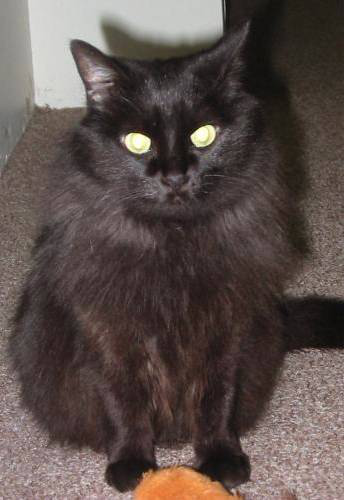

In [43]:
image

In [44]:
train_dataset.classes[label]

'cats'

In [45]:
len(train_dataset)

1500

In [49]:
train_dataset = PetDataset(root='cats_and_dogs_filtered/train', train=True, 
                               load_to_ram=True, transform=test_transform)

val_dataset = PetDataset(root='cats_and_dogs_filtered/train', train=False, 
                              load_to_ram=True, transform=test_transform)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
print(f'Число классов: {len(train_dataset.classes)}')

Число классов: 2


In [51]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=4)

# 5. Файнтьюним модель

Давайте отфайнтьюним `mobilenet`. Подгрузим все наши стандартные функции для обучения и воспользуемся ими.

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [53]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

**Attention!** Интерфейс torchvision.models поменялся в версии 0.13.

## 5.1 Попробуем обучить модель с нуля

In [54]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

num_epochs = 50
model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [55]:
# число обучаемых параметров в модели
sum(param.numel() for param in model.parameters())

2226434

Сделаем несколько эпох обучения для всех весов модели (файнтьюнин):

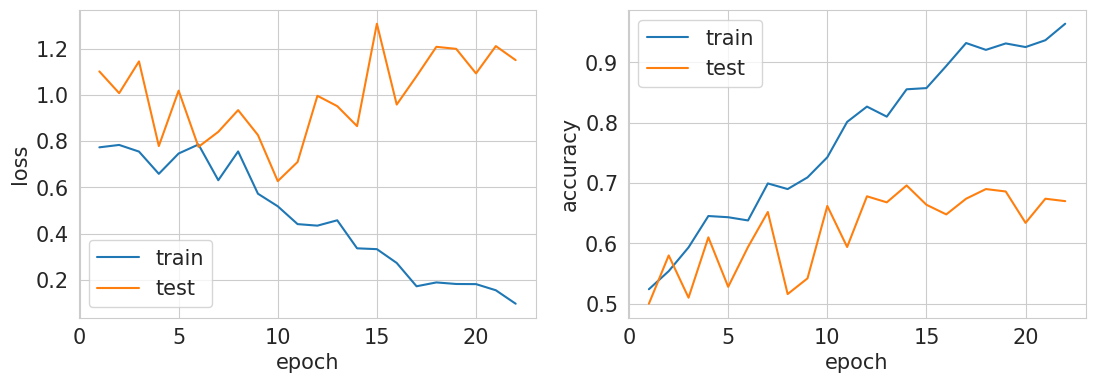

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

С нуля учить такую большую сетку на такой маленькой выборке оказалось не очень хорошей идеей. Accuracy на валидации на сбалансированной выборке едва дошла до 0.7.

## 5.2 Добавим аугментации

In [59]:
train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.5, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

In [60]:
train_dataset.transform = train_transform
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)

In [61]:
model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

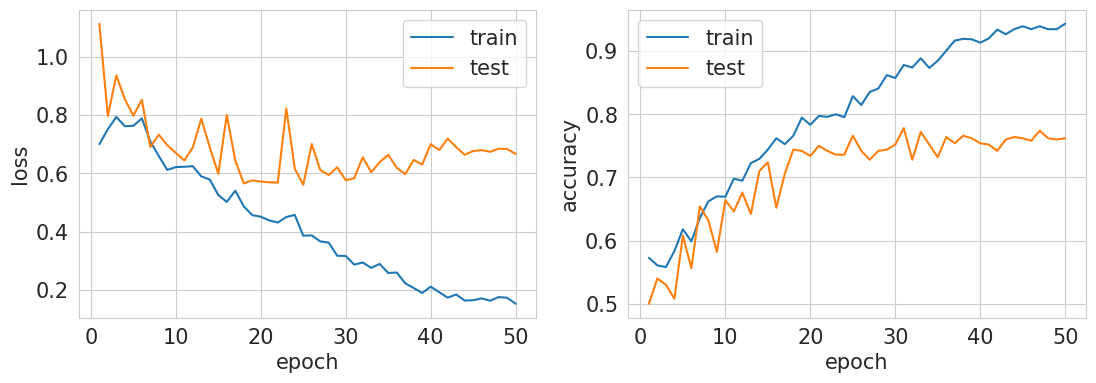

In [62]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

Благодаря аугментации данных, качество модели стало сильно лучше. Качество на валидации пробило 0.7 и почти добежало до 0.8

## 5.3 Сделаем файнтьюнинг предобученной модели

In [63]:
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Заменяем исходную голову модели на голову с правильным числом классов
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 118MB/s] 


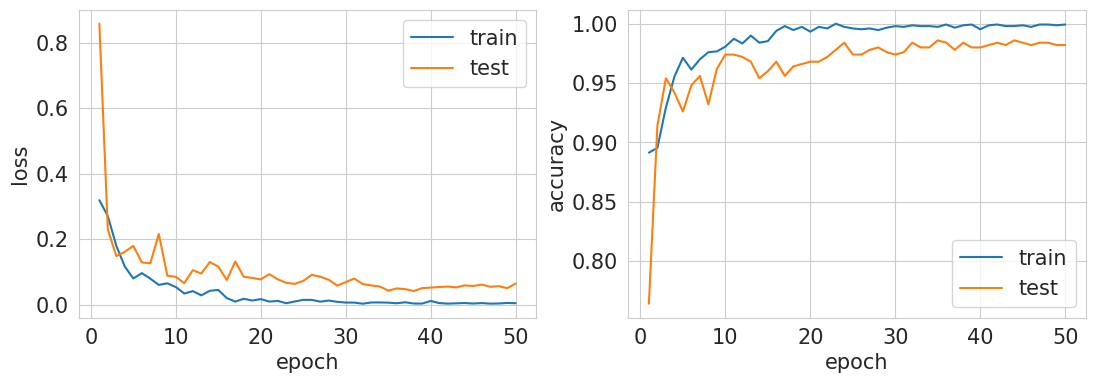

In [64]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

Ого! Что у нас за пушка на валидации.........

# 6. Transfer Learning

Выше мы файнтьюнили всю модель целиком. А можно доучить только последний слой. Запретим весам из экстрактора фичей обучаться. 

In [70]:
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

In [71]:
# Заменяем исходную голову модели на голову с правильным числом классов
# и с requires_grad=True by default
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)

Название слоя, который надо заменить можно узнать из вот этой портянки текста: 

In [72]:
model 

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [73]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

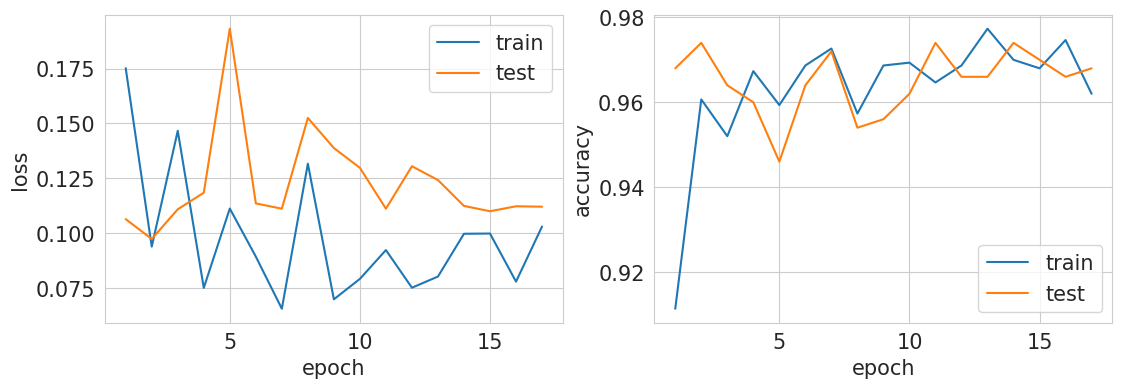

Training 18/50:   0%|          | 0/47 [00:00<?, ?it/s]

Validating 18/50:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

Обучение идёт в разы быстрее, чем для файнтьюна, потому что у нас простая задачка.

На паре я показывал как можно обучать модели через `pytorch_lightning`. Честно говоря, я начал жалеть, что показал это. Но вы можете попробовать разобраться в нём [вот тут.](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem04/sem04_solution.ipynb) Код для обучения модели [мы брали отсюда.](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem05/sem05_solution.ipynb)